In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
import joblib

# 1. The Story    
* The <b>context</b> of the experiment (fictious):    
Startup has developed a wellness mobile application. The app collects various health and lifestyle data from its users and aims to provide personalized health tips and recommendations.   
One feature that the startup wishes to integrate into the app is a diabetes risk prediction tool. This tool will analyze the user's data and provide an estimate of their diabetes risk. If the risk is high, the app would then recommend the user to consult a healthcare professional for further examination.
* The <b>goal</b> of this project is to create a machine learning model that accurately <b>predicts the risk of diabetes</b> based on various features like age, gender, family history of diabetes, lifestyle habits, and other health indicators.
* The <b>plan</b> is to evaluate the performance of three distinct classification algorithms: k-Nearest Neighbors, Support Vector Machines, and Decision Trees. Each will be fine-tuned on a suitable dataset to identify the best hyperparameters for model's optimal performance. Based on the results of this evaluation, we will select the most efficient algorithm to serve as our production model.

# 2. The Data     
The "Diabetes" dataset I've picked to train the model is [available on Kaggle](https://www.kaggle.com/datasets/tigganeha4/diabetes-dataset-2019). It seemed suitable as the features resemble a questionnaire answers and are devoid of advanced-knowledge information about one's health the wellness-app users may not posses (i.e., insulin or glucose blood levels). Besides, it has instances for both genders and different age groups.

In [3]:
diabetes_df = pd.read_csv("diabetes.csv")

In [4]:
diabetes_df.head(5)

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
0,50-59,Male,no,yes,one hr or more,39.0,no,no,8,6,no,occasionally,sometimes,high,0.0,0,not much,no
1,50-59,Male,no,yes,less than half an hr,28.0,no,no,8,6,yes,very often,sometimes,normal,0.0,0,not much,no
2,40-49,Male,no,no,one hr or more,24.0,no,no,6,6,no,occasionally,sometimes,normal,0.0,0,not much,no
3,50-59,Male,no,no,one hr or more,23.0,no,no,8,6,no,occasionally,sometimes,normal,0.0,0,not much,no
4,40-49,Male,no,no,less than half an hr,27.0,no,no,8,8,no,occasionally,sometimes,normal,0.0,0,not much,no


The features:
- **Age**: *'50-59', '40-49', 'less than 40', '60 or older'*
- **Gender**: *Male, Female*
- **Family_Diabetes**: having a family history of diabetes: *yes/no*
- **highBP**: having a history of high blood pressure: *yes/no*
- **PhysicallyActive**: duration of physical activity daily: *'one hr or more', 'less than half an hr', 'none', 'more than half an hr'*
- **BMI**: the Body Mass Index of the individual
- **Smoking**: *yes/no*
- **Alcohol**: *yes/no*
- **Sleep**: the average number of hours the individual sleeps per night
- **SoundSleep**: the average number of hours of sound sleep the individual gets per night
- **RegularMedicine**: whether the individual takes regular medication for any condition: *yes/no*
- **JunkFood**: the frequency of junk food consumption: *'occasionally', 'very often', 'often', 'always'*
- **Stress**: the frequency at which an individual experiences stress: *'sometimes', 'not at all', 'very often', 'always'*
- **BPLevel**: blood pressure level: *'high', 'normal', 'low'*
- **Pregnancies**: the number of pregnancies the individual has had (if applicable)
- **Pdiabetes**: whether the patient had gastational diabetes during pregnancy: *yes/no*
- **UrinationFreq**: the frequency of urination for the individual: *'not much', 'quite often'*     

The target:
- **Diabetic**: whether the individual has been diagnosed with diabetes: *yes/no*


In [5]:
print(f'Diabetes shape: {diabetes_df.shape}')

Diabetes shape: (952, 18)


# 3. IDA   
In this chapter we will look at some of the distributions and relationships of the features with the target variable to get insights on the potential significance of each feature in predicting the outcome.  

<div style="background-color: #F0FFF0; padding: 10px;">Let's begin by examining the distribution of our target variable: </div>

<Axes: xlabel='Diabetic'>

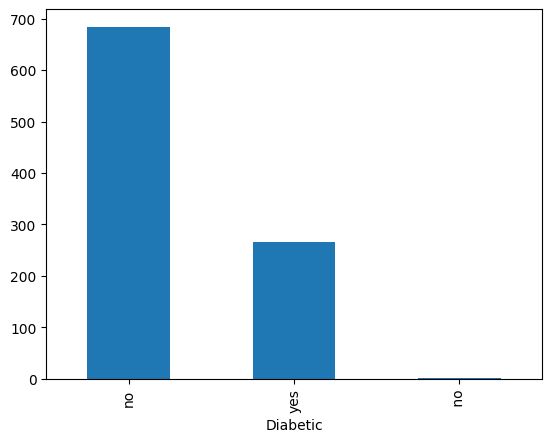

In [6]:
diabetes_df['Diabetic'].value_counts().plot(kind='bar')

In [7]:
diabetes_df.Diabetic.value_counts(normalize=True) * 100

Diabetic
no     71.924290
yes    27.970557
 no     0.105152
Name: proportion, dtype: float64

<div style="background-color: #F0FFF0; padding: 10px;">Our classes are <b>imbalanced</b>, ~ 72% of the total instances are of the "negative" class.</div>

In [ ]:
# Selecting the numerical/categorical columns from the df, and calculating the count
num_cols = len(diabetes_df.select_dtypes(include=[np.number]).columns)
cat_cols = len(diabetes_df.select_dtypes(include=['object']).columns)

total_cols = num_cols + cat_cols

num_cols_percent = (num_cols / total_cols) * 100
cat_cols_percent = (cat_cols / total_cols) * 100

print(f"Numerical Columns: {num_cols} ({num_cols_percent:.2f}%)")
print(f"Categorical Columns: {cat_cols} ({cat_cols_percent:.2f}%)")

Numerical Columns: 4 (22.22%)
Categorical Columns: 14 (77.78%)


<div style="background-color: #F0FFF0; padding: 10px;">Most of our columns are categorical. We will proceed with a countplot to see their distributions with respect to the target column: </div>

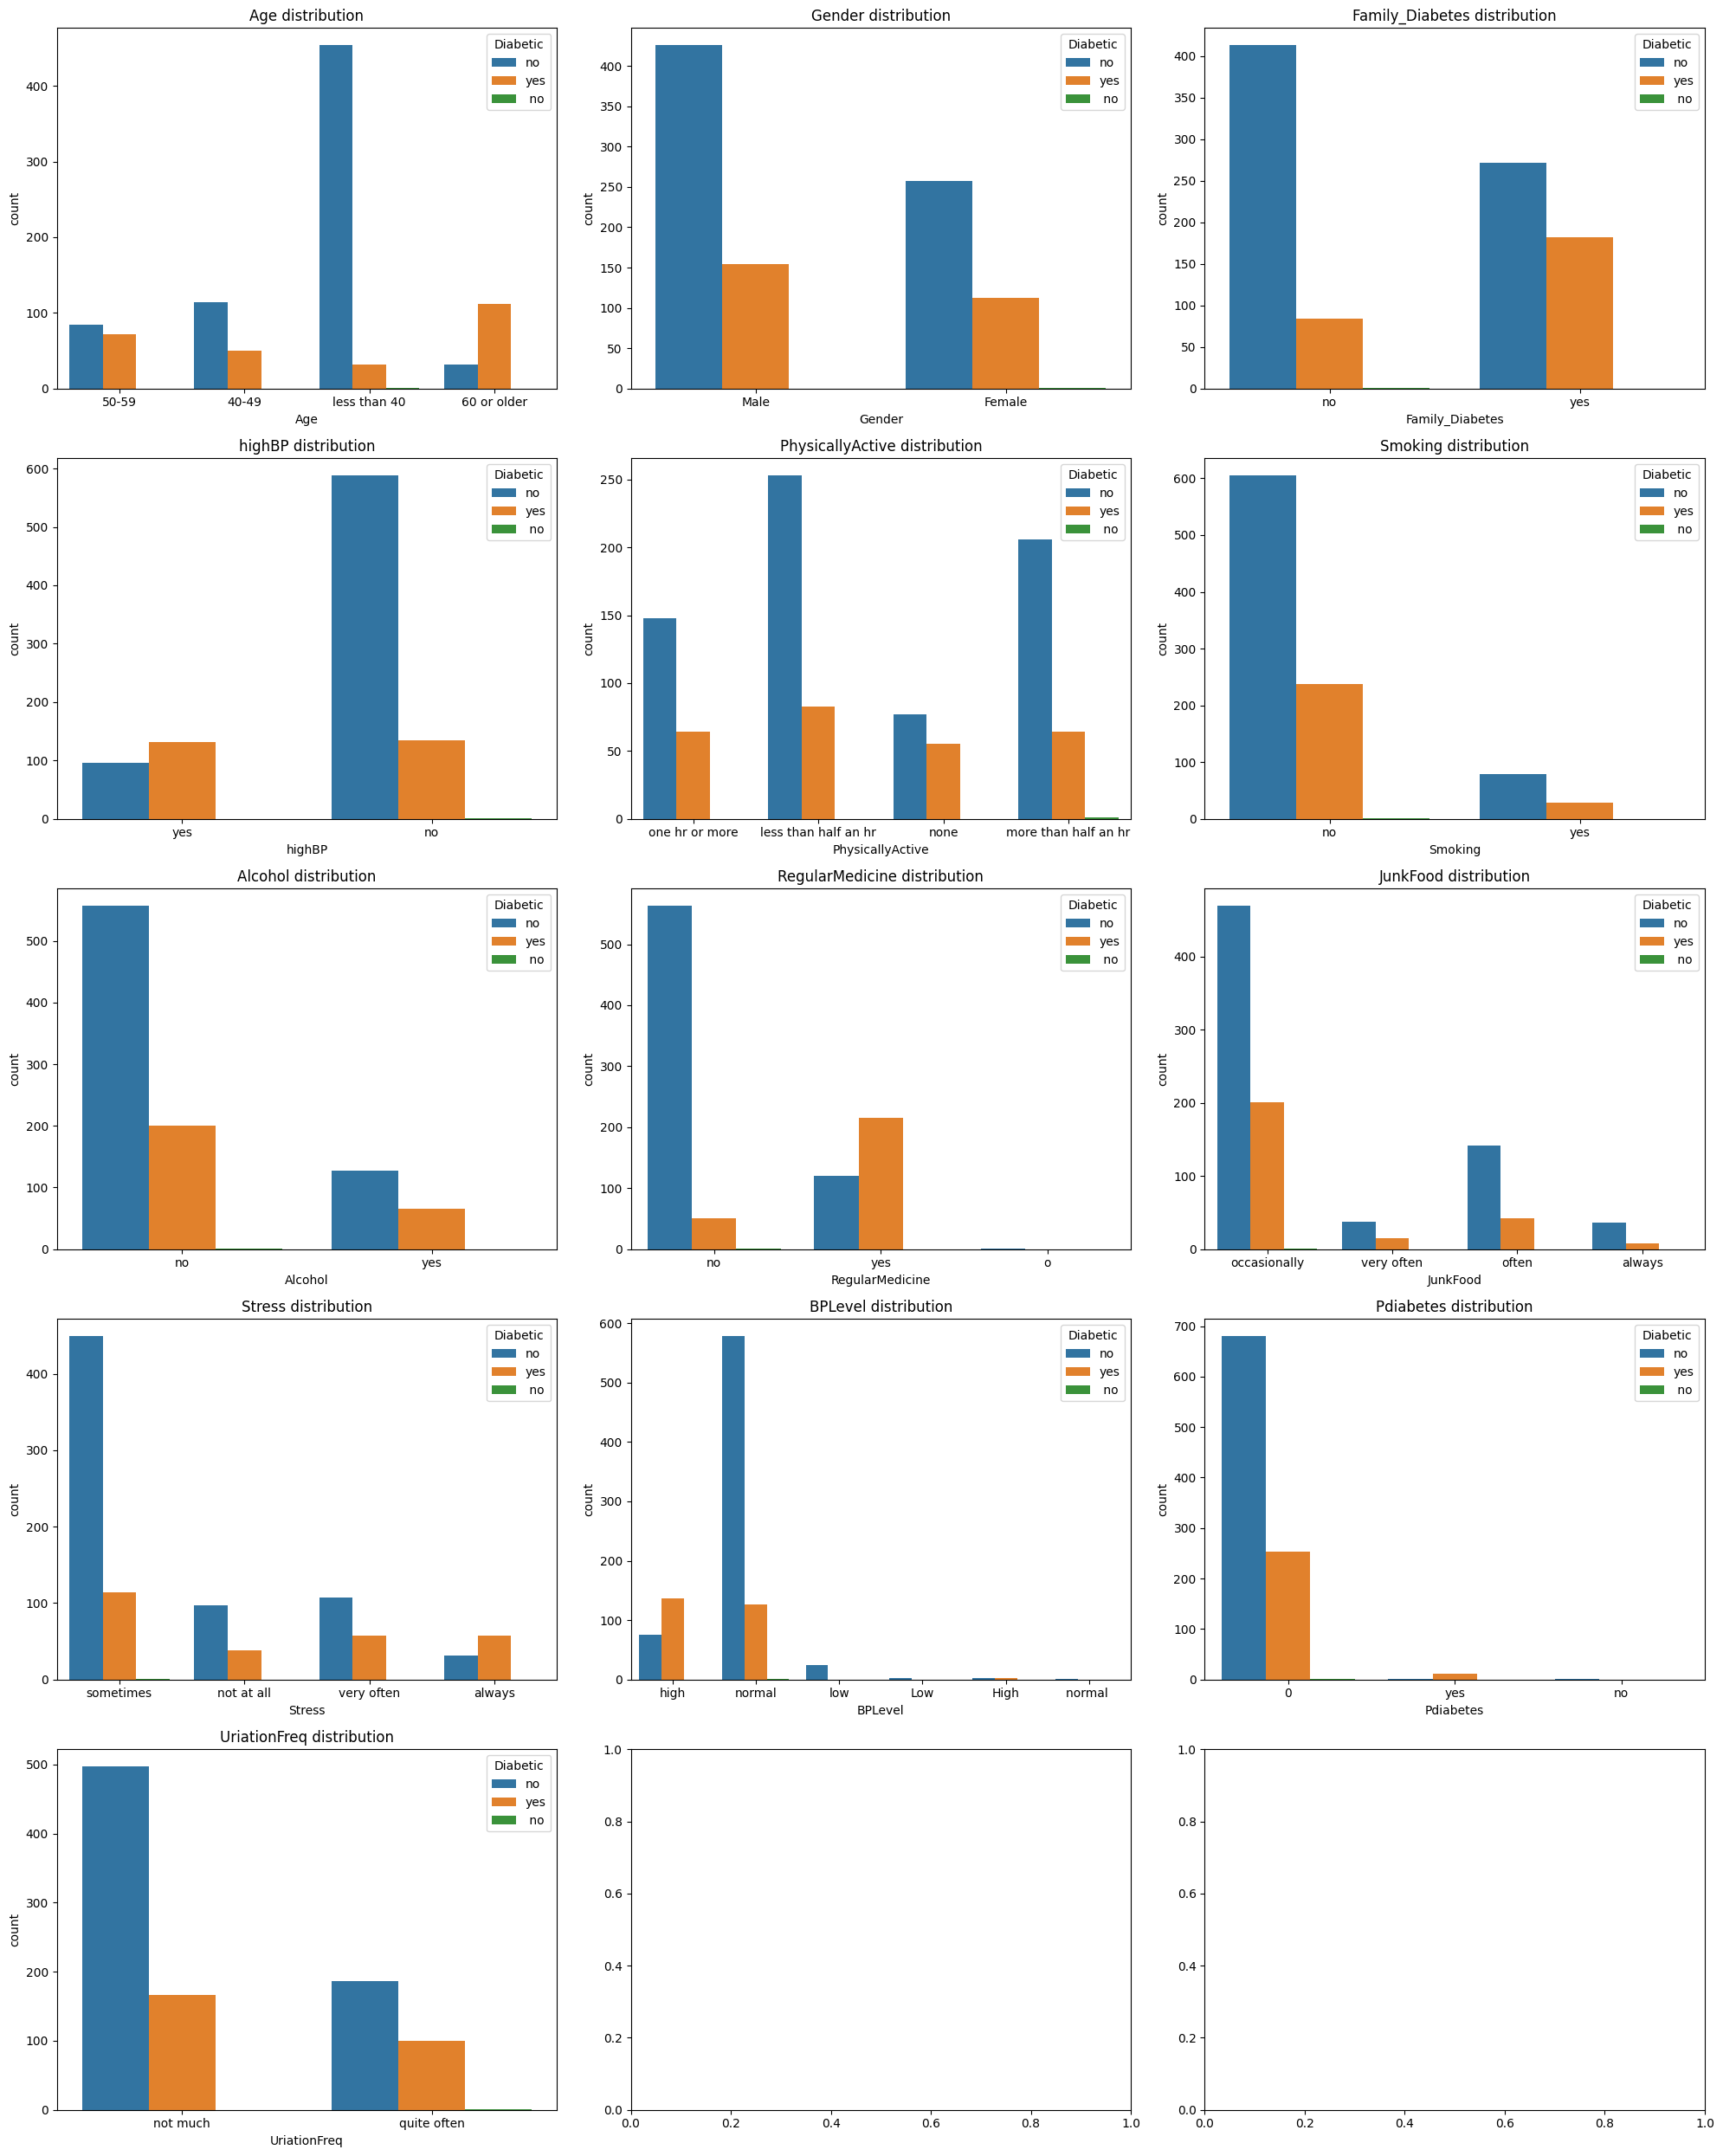

In [8]:
categorical_columns = diabetes_df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('Diabetic')

n = len(categorical_columns) # number of rows needed for the plots
ncols = 3 # number of columns for the subplot grid
nrows = n // ncols if n % ncols == 0 else n // ncols + 1 # number of rows needed for the subplot grid

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5*nrows))

for idx, cat_col in enumerate(categorical_columns): # a countplot for each categorical column
    row_num = idx // ncols
    col_num = idx % ncols
    ax = axes[row_num, col_num] # appropriate axis for the current plot
    sns.countplot(x=cat_col, data=diabetes_df, hue='Diabetic', ax=ax)
    ax.set_title(f'{cat_col} distribution')

plt.tight_layout() # so there is no overlap between plots
plt.show()

<div style="background-color: #F0FFF0; padding: 10px;">The interpretability of these plots for understanding the relationships between categorical variables and the target is somewhat compromised due to the major prevalence of the negative class. We can still note the higher overall presence of the positive class for 60+ years old people, people with the family history of diabetes, high blood pressure etc.    
To explore it further and identify the most significant categorical features, I will measure the dependence between categorical variables and the target using chi-square test of independence inbuilt in scipy.stats: </div>

In [ ]:
p_values = {}

for feature in categorical_columns:
    crosstab = pd.crosstab(diabetes_df[feature], diabetes_df['Diabetic']) # Contingency table
    chi2, p, dof, expected = chi2_contingency(crosstab) # Performing a chi-square test of independence
    if p < 1e-8:  # Threshold to format values
        p_values[feature] = "{:.3e}".format(p) # Then scientific notation
    else:
        p_values[feature] = "{:.5f}".format(p) # Else standard notation with 5 decimal places

# Converting to df and transposing for better visualisation
p_values_df = pd.DataFrame(p_values, index=['P-value']).transpose()

display(p_values_df)

,P-value
Age,6.037e-65
Gender,0.21082
Family_Diabetes,9.381e-15
highBP,1.077e-29
PhysicallyActive,0.00334
Smoking,0.90123
Alcohol,0.11377
RegularMedicine,2.209e-72
JunkFood,0.38864
Stress,3.156e-15


<div style="background-color: #F0FFF0; padding: 10px;">A small p-value (typically ≤ 0.05) indicates strong evidence that the feature is associated with the target variable. 'Age', 'Family_Diabetes', 'highBP', 'PhysicallyActive', 'RegularMedicine', 'Stress', 'BPLevel', 'Pdiabetes', 'UriationFreq' have small p-values, implying that they are significantly associated with the 'Diabetic' outcome. On the contrary, 'Gender', 'Smoking', 'Alcohol', and 'JunkFood' have larger p-values, implying lesser association. </div>

<div style="background-color: #F0FFF0; padding: 10px;">Now we will take a closer look at our numerical columns with their summary statistics: </div>

In [ ]:
diabetes_df.describe()

,BMI,Sleep,SoundSleep,Pregancies
count,948.000000,952.000000,952.000000,910.000000
mean,25.763713,6.949580,5.495798,0.386813
std,5.402595,1.273189,1.865618,0.909455
min,15.000000,4.000000,0.000000,0.000000
25%,22.000000,6.000000,4.000000,0.000000
50%,25.000000,7.000000,6.000000,0.000000
75%,29.000000,8.000000,7.000000,0.000000
max,45.000000,11.000000,11.000000,4.000000


<div style="background-color: #F0FFF0; padding: 10px;">BMI, Sleep and SoundSleep features seem to be symmetrically distributed (mean is very close to the median or 50% percentile), with potential high-end outliers in the BMI data (max is far from the 75th percentile) and low-end outliers in SoundSleep(min is somewhat far from 25%). In contrast, the Pregnancies variable shows a different pattern: 75% of the individuals report no past pregnancies, and the presence of a few cases with a larger number of instances appears to skew the mean. Its maximum exceeds the 75th percentile, suggesting high-end outliers.</div>

<div style="background-color: #F0FFF0; padding: 10px;">Lastly, we will visualize the relationships between our numerical features and diabetic status with a correlation heatmap: </div>

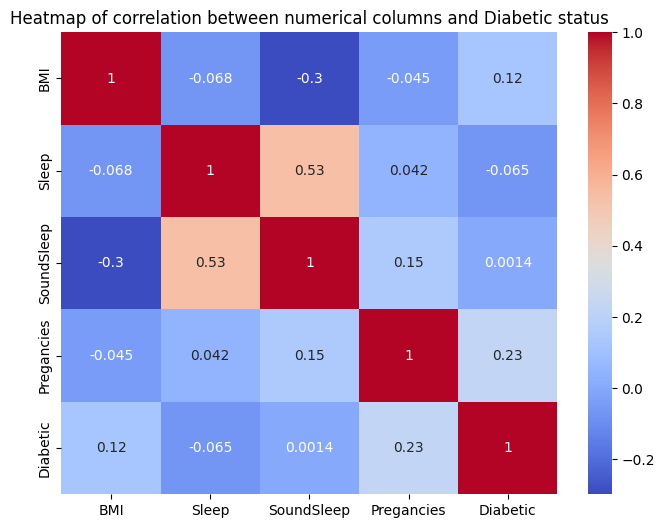

In [ ]:
numerical_columns = ['BMI', 'Sleep', 'SoundSleep', 'Pregancies']
diabetes_df_encoded = diabetes_df.copy()
# Encoding Diabetic column
diabetes_df_encoded['Diabetic'] = diabetes_df_encoded['Diabetic'].apply(lambda x: 1 if x == 'yes' else 0)

plt.figure(figsize=(8, 6))
sns.heatmap(diabetes_df_encoded[numerical_columns + ['Diabetic']].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of correlation between numerical columns and Diabetic status')
plt.show()

<div style="background-color: #F0FFF0; padding: 10px;">The correlations between our numerical columns and diabetes status are ranging from essentially none (0.0014) to weak (0.23). </div>

# 4. Preprocessing    
In this section we fix typos in features names and values, drop the rows with the missing data and encode categorical features (ordinal and binary encoding).   
We will also define our target and features.  

In [ ]:
# Fixing typos in column names
diabetes_df.rename(columns={'Pregancies': 'Pregnancies', 'UriationFreq': 'UrinationFreq'}, inplace=True)

# Fixing typos in the values
diabetes_df["Diabetic"].replace({" no": "no"}, inplace=True)
diabetes_df["BPLevel"].replace({"Low":"low", "High":"high", "Normal":"normal","normal ": "normal" }, inplace=True)
diabetes_df["Pdiabetes"].replace({"0": "no"}, inplace=True)
diabetes_df['RegularMedicine'] = diabetes_df['RegularMedicine'].replace('o', 'no')

In [ ]:
# Identifying missing values
missing_values = diabetes_df.isnull().sum()
print(f'\nMissing values in each column:\n{missing_values}')


Missing values in each column:
Age                  0
Gender               0
Family_Diabetes      0
highBP               0
PhysicallyActive     0
BMI                  4
Smoking              0
Alcohol              0
Sleep                0
SoundSleep           0
RegularMedicine      0
JunkFood             0
Stress               0
BPLevel              0
Pregnancies         42
Pdiabetes            1
UrinationFreq        0
Diabetic             1
dtype: int64


In [ ]:
initial_rows = len(diabetes_df)
# Dropping the rows with missing values
diabetes_df = diabetes_df.dropna()

# Calculating the percentage of dropped rows
dropped_rows = initial_rows - len(diabetes_df)
percentage_dropped = (dropped_rows / initial_rows) * 100
print(f"Percentage of dropped rows: {percentage_dropped:.2f}%")

Percentage of dropped rows: 4.94%


In [ ]:
# Customized mapping to 0 and 1
diabetes_df['Gender'] = diabetes_df['Gender'].map({'Male': 0, 'Female': 1})
diabetes_df['UrinationFreq'] = diabetes_df['UrinationFreq'].map({'not much': 0, 'quite often': 1})

In [ ]:
# Mapping the binary columns with "no" and "yes" to 0 and 1
binary_cols = ['Pregnancies', 'Pdiabetes', 'Family_Diabetes', 'Diabetic', 'highBP', 'Smoking', 'Alcohol', 'RegularMedicine']
diabetes_df[binary_cols] = diabetes_df[binary_cols].replace({'no': 0, 'yes': 1})

<div style="background-color: #F0FFF0; padding: 10px;">It seems appropriate to encode many of our columns <b>ordinally</b>, as it reflects the natural progression of the values, i.e. 'JunkFood' or 'Stress': the categories have a clear order from lower to higher frequency. This way we can avoid the high-dimensionality associated with Hot Encoding. </div>

In [ ]:
# To define the logical order of categories for ordinal columns
category_order = [
    ['occasionally', 'often', 'very often', 'always'],  # JunkFood
    ['not at all', 'sometimes', 'very often', 'always'],  # Stress
    ['low', 'normal', 'high'],  # BPLevel
    ['less than 40', '40-49', '50-59', '60 or older'], #Age
    ['none', 'less than half an hr', 'more than half an hr', 'one hr or more'] #PhysicallyActive

]

# Selecting the categorical columns for ordinal encoding
ordinal_cols = ['JunkFood', 'Stress', 'BPLevel', 'Age', 'PhysicallyActive']

# Performing ordinal encoding on the selected columns
ordinal_encoder = OrdinalEncoder(categories=category_order)
diabetes_df[ordinal_cols] = ordinal_encoder.fit_transform(diabetes_df[ordinal_cols])

<div style="background-color: #F0FFF0; padding: 10px;">Let's see if the data was pre-processed sucessfully: </div>

In [ ]:
diabetes_df.dtypes

Age                 float64
Gender                int64
Family_Diabetes       int64
highBP                int64
PhysicallyActive    float64
BMI                 float64
Smoking               int64
Alcohol               int64
Sleep                 int64
SoundSleep            int64
RegularMedicine       int64
JunkFood            float64
Stress              float64
BPLevel             float64
Pregnancies         float64
Pdiabetes             int64
UrinationFreq         int64
Diabetic              int64
dtype: object

In [ ]:
diabetes_df.head(5)

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregnancies,Pdiabetes,UrinationFreq,Diabetic
0,2.0,0,0,1,3.0,39.0,0,0,8,6,0,0.0,1.0,2.0,0.0,0,0,0
1,2.0,0,0,1,1.0,28.0,0,0,8,6,1,2.0,1.0,1.0,0.0,0,0,0
2,1.0,0,0,0,3.0,24.0,0,0,6,6,0,0.0,1.0,1.0,0.0,0,0,0
3,2.0,0,0,0,3.0,23.0,0,0,8,6,0,0.0,1.0,1.0,0.0,0,0,0
4,1.0,0,0,0,1.0,27.0,0,0,8,8,0,0.0,1.0,1.0,0.0,0,0,0


<div style="background-color: #F0FFF0; padding: 10px;">Finally, we will define target and features and set them apart:</div>

In [ ]:
X = diabetes_df.drop(columns='Diabetic')
y = diabetes_df['Diabetic']

# 5. A First Impression

In [ ]:
# Creating a single train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<div style="background-color: #F0FFF0; padding: 10px;">I chose the Dummy Classifier from scikit-learn as a reference point.</div>

In [ ]:
#----------- BASELINE/DUMMY --------------

baseline = DummyClassifier(strategy='stratified', random_state=42)
baseline.fit(X_train, y_train)

# Making predictions
y_pred_baseline = baseline.predict(X_test)

# Evaluating the baseline model
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f'Baseline Accuracy: {round(baseline_accuracy, 5)}')
baseline_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_baseline)
print(f'Baseline Balanced Accuracy: {round(baseline_balanced_accuracy, 5)}')

Baseline Accuracy: 0.58564
Baseline Balanced Accuracy: 0.47851


<div style="background-color: #F0FFF0; padding: 10px;">Next we will run SVM with default parameters to get an impression on the overall algorithm performance:</div>

In [ ]:
clf = SVC(random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training and predicting
start_time = time.time()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
total_time = time.time() - start_time

# Calculating evaluation metrics
clf_accuracy = accuracy_score(y_test, y_pred)
clf_baccuracy = balanced_accuracy_score(y_test, y_pred)

print(f'Default SVM Acc: {round(clf_accuracy, 5)}, Balanced Accuracy: {round(clf_baccuracy, 5)}')
print(f'Total Run Time: {round(total_time, 5)} seconds')


Default SVM Acc: 0.90608, Balanced Accuracy: 0.85861
Total Run Time: 0.00738 seconds


### First impression: conclusion     
From our preliminary results, we can observe that the problem may not be extremely difficult since the SVM model with default parameters was able to achieve decent performance on its own. This suggests that the features we have are indeed useful in predicting whether a person has diabetes or not.
* The model performed worse on the minority class (balanced accuracy lower than accuracy). However, the difference is not huge, which is a good sign.
* The model took very little time to run, which makes me hopeful the experiment can be feasible on my current hardware.

# 6. Algorithms and Parameters    
As was stated in the <b>plan</b>, my algorithms of choice in this experiment are <b>SVM, kNN and Decision Trees</b>. Next we going to explore the influence of their associated parameters.

## Exploring hyperparameter influence    

In [ ]:
def param_influence(clf, param_values, X_train, y_train, X_test, y_test, hyper_name, score_func, model_type='general'):
    """
    Analyzes the influence of a specified hyperparameter on the performance of a model.

    Parameters:
    clf: The machine learning model.
    param_values (list or array): A sequence of values for the hyperparameter to test.
    X_train, y_train (DataFrame or array): The training data and corresponding labels.
    X_test, y_test (DataFrame or array): The testing data and corresponding labels.
    hyper_name (str): The name of the hyperparameter to tune.
    score_func (function): The scoring function used to evaluate the performance of the model.
    model_type (str, optional): Type of the model. Default is 'general'. If model is 'svm', x-axis will be set to log-scale in plot.

    Returns:
    None. However, this function will output a table summarizing the scores and a plot showing the influence of the hyperparameter.
    """
    train_scores = []
    test_scores = []

    for val in param_values:
        clf.set_params(**{hyper_name: val}) # Setting the current hyperparameter value
        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        train_scores.append(score_func(y_train, y_train_pred))

        y_test_pred = clf.predict(X_test)
        test_scores.append(score_func(y_test, y_test_pred))

    # Creating a dataframe to store the results
    result_df = pd.DataFrame({hyper_name: param_values,
                              'Train Score': train_scores,
                              'Test Score': test_scores})

    result_df.set_index(hyper_name, inplace=True)

    # The transposed dataframe for improved display
    display_df = result_df.copy().transpose()
    display_df = display_df.applymap(lambda x: format(int(x), 'd') if x == x // 1 else format(x, '.5f')) #  Formating the display of numbers in the df
    display(display_df)

    # ----- Plotting -------
    sns.set(style="darkgrid") # sets the background with grid
    fig, ax1 = plt.subplots(figsize=(10, 5))
    color = 'tab:blue'
    ax1.set_xlabel(hyper_name)
    # The scores
    ax1.set_ylabel('Score', color=color)
    ax1.plot(result_df.index, result_df['Train Score'], color=color, label='Train Score')
    ax1.plot(result_df.index, result_df['Test Score'], color='tab:orange', label='Test Score')
    ax1.tick_params(axis='y', labelcolor=color)

    if model_type == 'svm':
        ax1.set_xscale('log') # then setting x-axis to log-scale

    plt.xticks(param_values)
    plt.legend()

    plt.show()

### SVM linear kernel: C influence

C,0.001,0.010,0.100,0.200,0.500,1.000,10.000,100.000
Train Score,0.50000,0.81766,0.87117,0.87079,0.86747,0.87336,0.87532,0.87532
Test Score,0.50000,0.79623,0.83326,0.83326,0.83326,0.83326,0.82684,0.82684


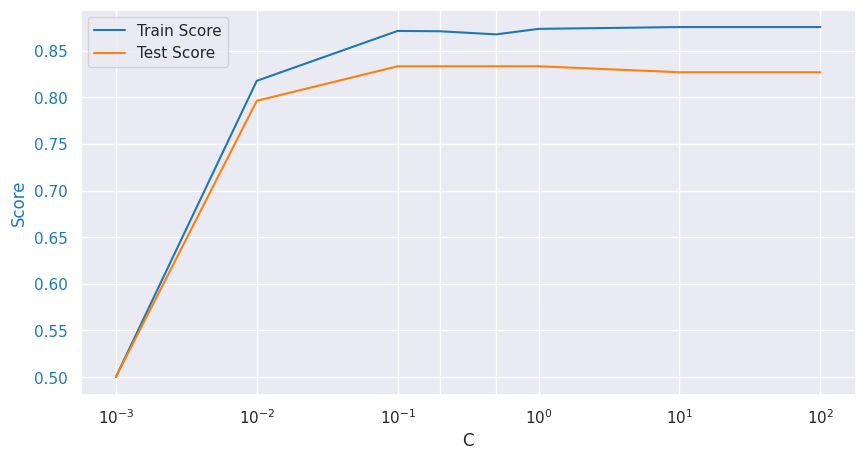

In [ ]:
Cs = (0.001, 0.01, 0.1, 0.2, 0.5, 1, 10, 100)
clf_svm_linear = SVC(kernel='linear')
param_influence(clf_svm_linear, Cs, X_train, y_train, X_test, y_test, hyper_name='C', score_func=balanced_accuracy_score, model_type='svm')

<div style="background-color: #F0FFF0; padding: 10px;">C value greater than 0.1 doesn't seem to improve the model's generalization ability (test score). </div>

### SVM rbf kernel

gamma,0.0001,0.0010,0.0100,0.1000,0.5000,1.0000,10.0000,100.0000,1000.0000
Train Score,0.73363,0.87434,0.91754,0.96570,0.96299,0.96299,0.96299,0.96299,0.96299
Test Score,0.67873,0.83326,0.84841,0.95161,0.94140,0.94140,0.94140,0.94140,0.94140


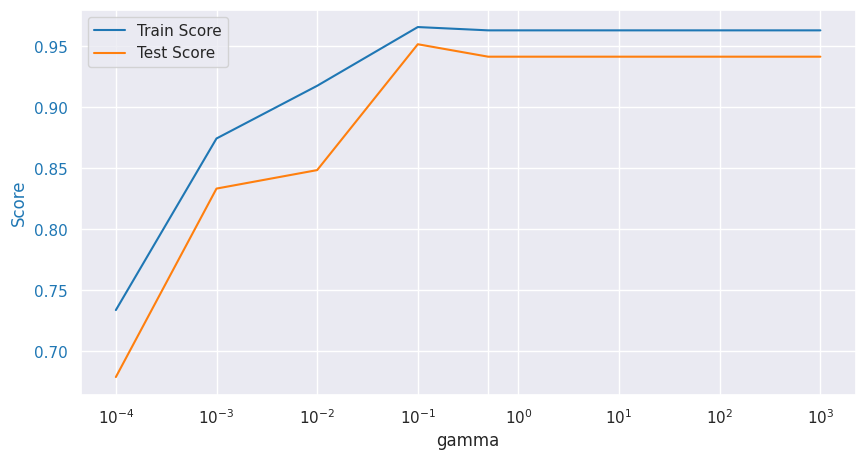

In [ ]:
gamma_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10, 100, 1000]
clf_rbf = SVC(kernel='rbf', C=15)
param_influence(clf_rbf, gamma_values, X_train, y_train, X_test, y_test, hyper_name='gamma', score_func=balanced_accuracy_score, model_type='svm')

<div style="background-color: #F0FFF0; padding: 10px;">Trying out different combinations of the gammas with the Cs, I was able to note that the test score reaches its highest (0.95) with the gamma 0.1 and C >= 10.
As we increase gamma beyond, the model does not show any further improvement in terms of accuracy. </div>

### SVM poly kernel

degree,1,2,3,4
Train Score,0.86724,0.88466,0.88760,0.88512
Test Score,0.83326,0.83326,0.83704,0.82684


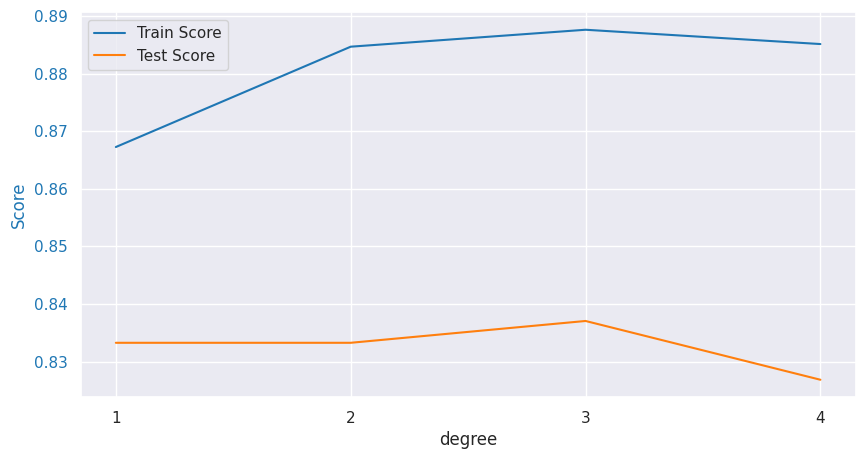

In [ ]:
degrees = [1, 2, 3, 4]
clf_poly = SVC(kernel='poly', C=50)
param_influence(clf_poly, degrees, X_train, y_train, X_test, y_test, hyper_name='degree', score_func=balanced_accuracy_score)

<div style="background-color: #F0FFF0; padding: 10px;">Depending on the choice of C, the model performance varies quite significantly, with either degree 2 or 3 having the best accuracy. It never outperformed RBF kernel, though. </div>

### Decision trees

max_depth,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Train Score,0.82358,0.83950,0.88005,0.89000,0.90064,0.93946,0.94497,0.94731,0.93631,0.96178,0.96299,0.96299,0.96299,0.96299,0.96299,0.96299,0.96299,0.96299,0.96299,0.96299
Test Score,0.80063,0.84230,0.83210,0.84988,0.87786,0.90847,0.91226,0.91226,0.91721,0.94024,0.95161,0.94140,0.94140,0.94140,0.94140,0.94140,0.94140,0.94140,0.94140,0.94140


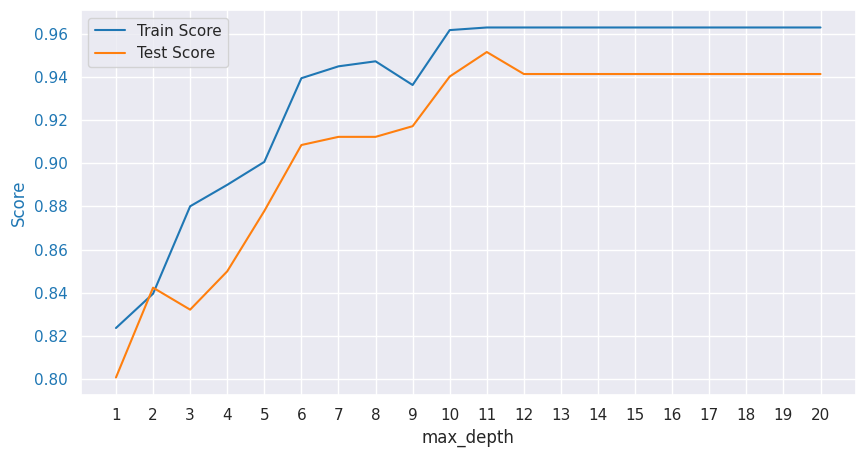

In [ ]:
# ----------- Decision Trees -------------------
depth_values = list(range(1, 21))
clf_tree = DecisionTreeClassifier(random_state=42)
param_influence(clf_tree, depth_values, X_train, y_train, X_test, y_test, hyper_name='max_depth', score_func=balanced_accuracy_score)

<div style="background-color: #F0FFF0; padding: 10px;">The test score reached its max with max_depth of 11, and stabilized at 12, which suggests that increasing the depth beyond this point doesn't improve the model's performance on unseen data. The performance matched SVM RBF kernel and looks promising.</div>

### kNN

n_neighbors,2,3,4,5,6,7,8,9,10,11,...,15,16,17,18,19,20,21,22,23,24
Train Score,0.94860,0.95870,0.93262,0.93585,0.81187,0.84217,0.76160,0.78880,0.70085,0.73913,...,0.72436,0.69829,0.70665,0.69987,0.71155,0.69543,0.69791,0.68819,0.69053,0.64380
Test Score,0.93499,0.94140,0.83936,0.84988,0.68514,0.71459,0.68777,0.72217,0.62013,0.67757,...,0.66095,0.63033,0.65074,0.60993,0.60993,0.60730,0.60351,0.61866,0.63907,0.60846


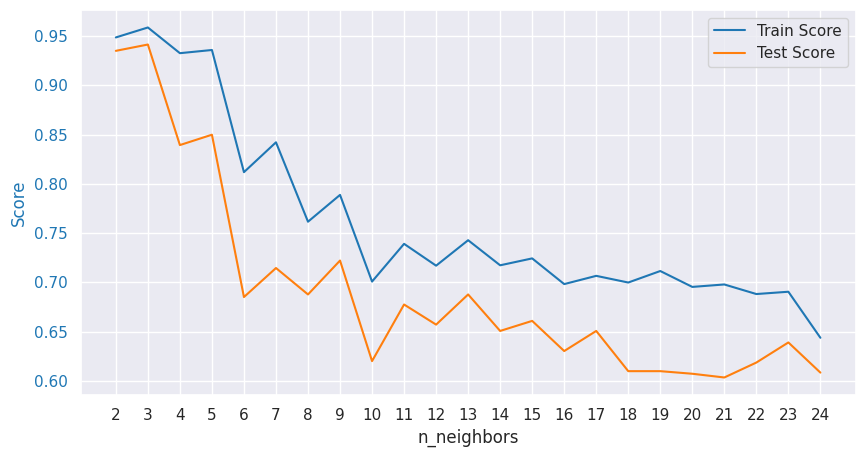

In [ ]:
nn_values = list(range(2, 25))
clf_kNN = KNeighborsClassifier()
param_influence(clf_kNN, nn_values, X_train, y_train, X_test, y_test, hyper_name='n_neighbors', score_func=balanced_accuracy_score)

<div style="background-color: #F0FFF0; padding: 10px;">The KNN model's performance appears to be best when the number of neighbors is 3, after that point both the training and testing accuracies decrease. With n_neighbors = 6, the drop in accuracy is very significant. The performance with 3 neighbours was on par with Decision Trees and SVM (rbf). </div>

## Conclusion and parameters grids
<b>Decision Trees:</b>     
* max_depth: our test accuracy reached its max at max_depth of 11. However, to be safe, we will explore a little more around this value: [8, 9, 10, 11, 12, 13]    
* for criterion, we going to include both ["gini", "entropy"]    

<b>k-Nearest Neighbors:</b>        
* n_neighbors: our results showed high test accuracy for 2 and 3 neighbors, but to avoid overfitting, we will explore a bit further with n_neighbors values in range of 2 to 10.   

<b>Support Vector Machine (SVM): </b>     
* C: from the results with the linear kernel, we can see that after C = 0.1, there isn't much change. However, with the RBF and polynomial kernel, the behavior may be different, so for C we going to try values [0.05, 0.1, 0.5, 1, 5, 10, 15, 20].     
* gamma (RBF): gamma of 0.1 gives high accuracy, so we will test around this value with [0.005, 0.01, 0.05, 0.1, 0.5, 1]
* degree (poly): we going to run the test with degrees 1-4

In [ ]:
# Decision Trees
dtree_grid = {"estimator__criterion": ["gini", "entropy"],
              "estimator__max_depth": [8, 9, 10, 11, 12, 13]}

# k-Nearest Neighbors
knn_grid = {"estimator__weights" : ["uniform", "distance"],
            "estimator__n_neighbors" : [*range(2,11)]}

# SVM with RBF Kernel
svm_rbf_grid = {"estimator__C": [0.05, 0.1, 0.5, 1, 5, 10, 15, 20],
                "estimator__gamma": [0.005, 0.01, 0.05, 0.1, 0.5, 1],
                "estimator__kernel": ['rbf']}

# SVM Poly Kernel
poly_grid = {"estimator__C": [0.05, 0.1, 0.5, 1, 5, 10, 15, 20],
             "estimator__degree" : [1,2,3,4]}

In [ ]:
baseline_grid = {} # As no hyperparameters to tune for baseline

# 7. Nested Cross-Validation    
Now we will see if we had an overly optimistic performance estimates in our previous chapter by setting up a Nested Cross Validation evaluation.      
We are also aiming to address the class imbalance we determined earlier by:
* Using <b>SMOTE</b> (Synthetic Minority Over-sampling Technique) within our imblearn pipeline. The imblearn version applies the resampling methods only on the training data and not on the validation/test data.
* Using Repeated <b>Stratified</b> KFold during our hyperparameter tuning phase (GridSearchCV). This is to ensure that the training set and the test set have roughly the same class distribution as original data in each fold.
* Using <b>Stratified</b> KFold during our model evaluation phase (cross_validate), again to ensure that the folds are made by preserving the percentage of samples for each class.  
* Including <b>balanced accuracy</b> and <b>F1</b> score as our performance metrics. We will also look at <b>recall</b>, as in our use case False Negatives are potentially costly (incorrectly predicting that a person does not have diabetes when they actually do, which could have health implications).

In [ ]:
# Global configurations
NUM_TRIALS = 10
NUM_INNER_REPEATS = 10
NUM_INNER_SPLITS = 10
NUM_OUTER_SPLITS = 10

In [ ]:
def get_pipe(estimator):
    return imbPipeline([("scaler", StandardScaler()),
                        ("smote", SMOTE(random_state=42)),
                        ("estimator", estimator)])

In [ ]:
# -------------- Nested cross-validation -----------------
def nested_cv(estimator, grid, features, targets):
    start = time.time()
    accs = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    baccs = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    f1s = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    recalls = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    fit_times = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    test_times = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))

    for i in range(NUM_TRIALS):
        print(f"Running Outer CV in iteration {i} at {time.time() - start} seconds")
        pipe = get_pipe(estimator)
        inner_cv = RepeatedStratifiedKFold(n_splits=NUM_INNER_SPLITS, n_repeats=NUM_INNER_REPEATS, random_state=i)
        outer_cv = StratifiedKFold(n_splits=NUM_OUTER_SPLITS, shuffle=True, random_state=i)
        clf=GridSearchCV(estimator=pipe, param_grid=grid, cv=inner_cv, scoring="balanced_accuracy", n_jobs=8, refit="balanced_accuracy")
        cv_results = cross_validate(clf, X=features, y=targets, cv=outer_cv, scoring=["accuracy", "balanced_accuracy", "f1", "recall"], n_jobs=8)
        accs[i] = cv_results["test_accuracy"]
        baccs[i] = cv_results["test_balanced_accuracy"]
        f1s[i] = cv_results["test_f1"]
        recalls[i] = cv_results["test_recall"]
        fit_times[i] = cv_results["fit_time"]
        test_times[i] = cv_results["score_time"]

    print("total time: ", time.time() - start)

    return accs, baccs, fit_times, test_times, f1s, recalls

In [ ]:
# Function to add results to a dataframe
def add_results(results, name, accs, baccs, fit_times, test_times, f1s, recalls):
    row = {
        "name" : name,
        "acc_mean" : accs.mean(),
        "acc_std" : accs.std(),
        "bacc_mean" : baccs.mean(),
        "bacc_std" : baccs.std(),
        "f1_mean": f1s.mean(),
        "f1_std": f1s.std(),
        "recall_mean": recalls.mean(),
        "recall_std": recalls.std(),
        "fit_mean" : fit_times.mean(),
        "test_mean" : test_times.mean()

    }
    return pd.concat([results, pd.DataFrame([row])], ignore_index=True)

In [ ]:
results = pd.DataFrame()

## Running Nested CV

In [ ]:
dtree = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier()
svc = SVC(kernel="rbf", random_state=42)
poly_svm = SVC(kernel="poly", random_state=42)

In [ ]:
print("Performing Nested CV for Baseline model...")
accs, baccs, fit_times, test_times, f1s, recalls = nested_cv(baseline, baseline_grid, X, y)
results = add_results(results, "Baseline", accs, baccs, fit_times, test_times, f1s, recalls)

Performing Nested CV for Baseline model...
Running Outer CV in iteration 0 at 1.5020370483398438e-05 seconds
Running Outer CV in iteration 1 at 3.9982805252075195 seconds
Running Outer CV in iteration 2 at 7.553588151931763 seconds
Running Outer CV in iteration 3 at 10.659572124481201 seconds
Running Outer CV in iteration 4 at 13.917211055755615 seconds
Running Outer CV in iteration 5 at 17.05722427368164 seconds
Running Outer CV in iteration 6 at 20.191911458969116 seconds
Running Outer CV in iteration 7 at 24.396427154541016 seconds
Running Outer CV in iteration 8 at 27.487422466278076 seconds
Running Outer CV in iteration 9 at 31.099446773529053 seconds
total time:  34.23812675476074


In [ ]:
print("Performing Nested CV for Decision Tree model...")
accs, baccs, fit_times, test_times, f1s, recalls = nested_cv(dtree, dtree_grid, X, y)
results = add_results(results, "Decision Tree", accs, baccs, fit_times, test_times, f1s, recalls)


Performing Nested CV for Decision Tree model...
Running Outer CV in iteration 0 at 1.1444091796875e-05 seconds
Running Outer CV in iteration 1 at 47.840696811676025 seconds
Running Outer CV in iteration 2 at 94.68601870536804 seconds
Running Outer CV in iteration 3 at 139.8026819229126 seconds
Running Outer CV in iteration 4 at 186.032573223114 seconds
Running Outer CV in iteration 5 at 232.11681079864502 seconds
Running Outer CV in iteration 6 at 280.4095652103424 seconds
Running Outer CV in iteration 7 at 327.85897946357727 seconds
Running Outer CV in iteration 8 at 373.9264671802521 seconds
Running Outer CV in iteration 9 at 420.505419254303 seconds
total time:  467.2025890350342


In [ ]:
print("Performing Nested CV for kNN model...")
accs, baccs, fit_times, test_times, f1s, recalls = nested_cv(knn, knn_grid, X, y)
results = add_results(results, "kNN", accs, baccs, fit_times, test_times, f1s, recalls)


Performing Nested CV for kNN model...
Running Outer CV in iteration 0 at 8.821487426757812e-06 seconds
Running Outer CV in iteration 1 at 111.34342813491821 seconds
Running Outer CV in iteration 2 at 225.4298117160797 seconds
Running Outer CV in iteration 3 at 336.54658484458923 seconds
Running Outer CV in iteration 4 at 450.33502435684204 seconds
Running Outer CV in iteration 5 at 565.0734076499939 seconds
Running Outer CV in iteration 6 at 681.0668349266052 seconds
Running Outer CV in iteration 7 at 792.4834554195404 seconds
Running Outer CV in iteration 8 at 905.6748738288879 seconds
Running Outer CV in iteration 9 at 1015.3436989784241 seconds
total time:  1129.0848233699799


In [ ]:
print("Performing Nested CV for SVM(RBF) model...")
accs, baccs, fit_times, test_times, f1s, recalls = nested_cv(svc, svm_rbf_grid, X, y)
results = add_results(results, "SVM_rbf", accs, baccs, fit_times, test_times, f1s, recalls)

Performing Nested CV for SVM(RBF) model...
Running Outer CV in iteration 0 at 1.6689300537109375e-05 seconds
Running Outer CV in iteration 1 at 278.3478481769562 seconds
Running Outer CV in iteration 2 at 555.5344936847687 seconds
Running Outer CV in iteration 3 at 829.8068897724152 seconds
Running Outer CV in iteration 4 at 1108.675443649292 seconds
Running Outer CV in iteration 5 at 1386.7531456947327 seconds
Running Outer CV in iteration 6 at 1662.9566974639893 seconds
Running Outer CV in iteration 7 at 1930.8944494724274 seconds
Running Outer CV in iteration 8 at 2206.982251882553 seconds
Running Outer CV in iteration 9 at 2481.7875986099243 seconds
total time:  2753.0872914791107


In [ ]:
print("Performing Nested CV for SVM(Poly) model...")
accs, baccs, fit_times, test_times, f1s, recalls = nested_cv(poly_svm, poly_grid, X, y)
results = add_results(results, "SVM_poly", accs, baccs, fit_times, test_times, f1s, recalls)

Performing Nested CV for SVM(Poly) model...
Running Outer CV in iteration 0 at 1.33514404296875e-05 seconds
Running Outer CV in iteration 1 at 182.95097875595093 seconds
Running Outer CV in iteration 2 at 360.2096571922302 seconds
Running Outer CV in iteration 3 at 541.0055902004242 seconds
Running Outer CV in iteration 4 at 720.3642649650574 seconds
Running Outer CV in iteration 5 at 902.8450050354004 seconds
Running Outer CV in iteration 6 at 1083.5690338611603 seconds
Running Outer CV in iteration 7 at 1265.7995619773865 seconds
Running Outer CV in iteration 8 at 1445.2085876464844 seconds
Running Outer CV in iteration 9 at 1618.2858529090881 seconds
total time:  1798.3441352844238


## Results

In [ ]:
results.sort_values(by="bacc_mean")

,name,acc_mean,acc_std,bacc_mean,bacc_std,f1_mean,f1_std,recall_mean,recall_std,fit_mean,test_mean
4,Baseline,0.486178,0.042145,0.501493,0.051247,0.378297,0.051049,0.538048,0.072956,1.923614,0.007604
0,SVM_poly,0.935915,0.023505,0.924045,0.028879,0.890570,0.038983,0.895741,0.058591,101.616483,0.009134
1,SVM_rbf,0.945084,0.021675,0.932066,0.027661,0.905107,0.036960,0.901040,0.056081,153.712547,0.009457
2,kNN,0.958015,0.019629,0.941173,0.028693,0.925293,0.036040,0.901040,0.056215,77.509683,0.070460
3,Decision Tree,0.961222,0.019907,0.944119,0.028715,0.930761,0.036362,0.903348,0.054412,25.203313,0.007041


### Nested CV: results and recommendations   
The 4 ML models (kNN, SVM(rbf and poly kernels), Decision Trees) outperform the baseline significantly.   
* The <b>Decision Tree</b> has the highest average accuracy, balanced accuracy, F1 score and recall among the models, indicating the <b>highest overall performance</b>. It also exhibits a relatively low standard deviation in metrics, suggesting stable performance across different folds. Furthermore, its fit time is the lowest.
* The <b>SVM</b> models also performs very well, but its fit time is considerably higher than the other models. Even though, in our case, it's not a concern of the highest priority, as our model would not be retrained frequently, rather periodically, still the extra computational cost is not justified given that the Decision Trees and kNN performance is not just comparable but better.     
* The <b>kNN</b> model demonstrates strong performance, with its accuracy, balanced accuracy, and F1 score being slightly lower than the Decision Tree but higher than the SVM models.   

<b>Recommendation</b>: Decision Trees, due to the overall performance and computational efficiency, is our model of choice.


# 8. Final Production Model      
In this chapter, we are going to finalize the choice of the Decision Trees model hyperparameters and train the model for production.    
We will also use the stored model to make a little prediction on a new data instance.  

In [ ]:
def train_prod_model(estimator, grid):
    """
    Trains the production model using the given estimator and grid for hyperparameter tuning.

    Parameters:
    estimator: The machine learning algorithm to be used.
    grid: Dictionary containing hyperparameters for the estimator.

    Returns:
    GridSearchCV object.
    """
    pipe = get_pipe(estimator)
    cv = RepeatedStratifiedKFold(n_splits=NUM_INNER_SPLITS, n_repeats=NUM_INNER_REPEATS, random_state=42)
    clf = GridSearchCV(estimator=pipe, param_grid=grid, cv=cv, n_jobs=8)
    clf.fit(X, y)
    return clf

In [ ]:
# ------------- Training the production model ----------------

clf_dt = train_prod_model(dtree, dtree_grid)
print(clf_dt.best_params_)

{'estimator__criterion': 'entropy', 'estimator__max_depth': 13}


<div style="background-color: #F0FFF0; padding: 10px;">The best parameters for our model are using 'entropy' as the criterion and a max tree depth of 13. </div>

<div style="background-color: #F0FFF0; padding: 10px;">Now, to get an idea how the model performs for each class, we will plot a confusion matrix:</div>

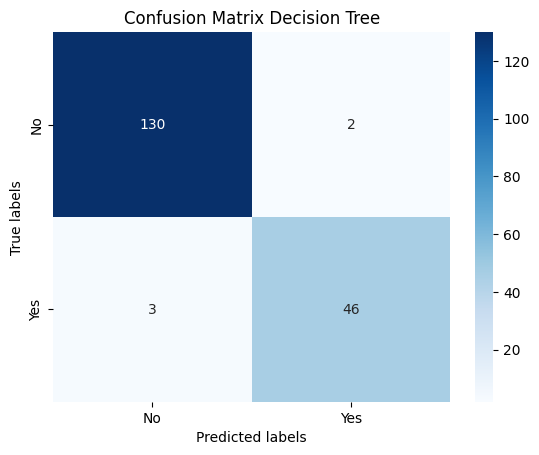

In [ ]:
#---------- CONFUSION MATRIX ----------------

# Generating predictions with our final model
y_pred = clf_dt.predict(X_test)

# Creating the matrix
cm_dt = confusion_matrix(y_test, y_pred)

# Plotting
ax = plt.subplot()
sns.heatmap(cm_dt, annot=True, fmt='g', ax=ax, cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix Decision Tree')
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])

plt.show()


<div style="background-color: #F0FFF0; padding: 10px;">As we see, the model correctly identified 46 cases of diabetes and correctly asserted the absence of the disease in 130 instances. There were relatively few errors, with the model incorrectly predicting diabetes in 2 instances and failing to identify it in 3 instances. </div>

<div style="background-color: #F0FFF0; padding: 10px;">Let's store our model in a suitable format:</div>

In [ ]:
joblib.dump(clf_dt, "diabetes_model.pkl")

['diabetes_model.pkl']

#  9. Conclusions and Future Work   
<b>*Summary of the achieved results:*</b>   
The machine learning model's goal was to predict the risk of diabetes accurately using various lifestyle and health indicators. Three algorithms, k-Nearest Neighbors (kNN), Support Vector Machines (SVM), and Decision Trees, were evaluated using nested cross-validation on a suitable diabetes dataset.

The <b>Decision Tree</b> model, with a maximum tree depth of 13 and using entropy, was determined as the best model based on its overall performance and specifically <b>balanced accuracy (0.94)</b> and <b>F1 score (0.93)</b>. It was also the most computationally efficient model.

<b>Generated value:</b> With the model implemented, the app can provide accurate diabetes risk assessments, encouraging users with high risks to seek professional medical advice. This increases the app's usefulness, potentially leading to better user engagement and retention.    

<b>*Critical assessment and possible improvements:*</b>    
I believe, the approach chosen for this task suits the context and the goal well overall. The selected dataset was appropriate, with simpler health indicators, accessible to average wellness app users.

However, what could potentially improve the model:
* Expanded Dataset: having access to a larger and more diverse dataset would enable more generalized model training
* Outliers: were not fully investigated, although the IDA suggested their potential presence. I believe in the medical context/domain they are informative and shouldn't be, for example, removed, yet a comparison between our current results and those obtained from a version of our dataset where outliers have been appropriately handled could be done.
* Exploring other resampling techniques for addressing the class imbalance
* Trying out ensemble methods (i.e., Random Forests)
